In [1]:
! pip install tensorflow pandas numpy scikit-learn xgboost optuna joblib tabulate


^C


In [3]:
! pip install numpy==numpy~=1.24.3


Defaulting to user installation because normal site-packages is not writeable


ERROR: Ignored the following versions that require a different python version: 1.21.2 Requires-Python >=3.7,<3.11; 1.21.3 Requires-Python >=3.7,<3.11; 1.21.4 Requires-Python >=3.7,<3.11; 1.21.5 Requires-Python >=3.7,<3.11; 1.21.6 Requires-Python >=3.7,<3.11
ERROR: Could not find a version that satisfies the requirement numpy==numpy~=1.24.3 (from versions: 1.3.0, 1.4.1, 1.5.0, 1.5.1, 1.6.0, 1.6.1, 1.6.2, 1.7.0, 1.7.1, 1.7.2, 1.8.0, 1.8.1, 1.8.2, 1.9.0, 1.9.1, 1.9.2, 1.9.3, 1.10.0.post2, 1.10.1, 1.10.2, 1.10.4, 1.11.0, 1.11.1, 1.11.2, 1.11.3, 1.12.0, 1.12.1, 1.13.0, 1.13.1, 1.13.3, 1.14.0, 1.14.1, 1.14.2, 1.14.3, 1.14.4, 1.14.5, 1.14.6, 1.15.0, 1.15.1, 1.15.2, 1.15.3, 1.15.4, 1.16.0, 1.16.1, 1.16.2, 1.16.3, 1.16.4, 1.16.5, 1.16.6, 1.17.0, 1.17.1, 1.17.2, 1.17.3, 1.17.4, 1.17.5, 1.18.0, 1.18.1, 1.18.2, 1.18.3, 1.18.4, 1.18.5, 1.19.0, 1.19.1, 1.19.2, 1.19.3, 1.19.4, 1.19.5, 1.20.0, 1.20.1, 1.20.2, 1.20.3, 1.21.0, 1.21.1, 1.22.0, 1.22.1, 1.22.2, 1.22.3, 1.22.4, 1.23.0, 1.23.1, 1.23.2, 1.23.

In [ ]:
!

In [2]:

import tensorflow as tf
from tensorflow.keras import layers, models
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import HalvingRandomSearchCV
import optuna
import joblib
from tabulate import tabulate
import pickle

C:\Users\mosa\AppData\Roaming\Python\Python311\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:

df = pd.read_csv('clean_data.csv')

# فصل المزايا والتسميات
X = df[[col for col in df.columns if col != 'label']].values
y = df['label'].values

# إعادة تشكيل البيانات لـ CNN (21 زوج x,y → 7x6 صورة ثنائية الأبعاد)
n_samples = len(X)
n_pairs = X.shape[1] // 2  # 21 زوجًا
img_height = 7  # يمكنك تعديل هذه القيم حسب احتياجاتك
img_width = 6   # يمكنك تعديل هذه القيم حسب احتياجاتك
X_reshaped = X.reshape(n_samples, img_height, img_width, 1)

# تحويل التسميات إلى one-hot encoding
y = tf.keras.utils.to_categorical(y, num_classes=43)

# تقسيم البيانات
X_train_cnn, X_test_cnn, y_train_cnn, y_test_cnn = train_test_split(X_reshaped, y, test_size=0.2, random_state=42)

# تحضير بيانات لنماذج أخرى (بدون إعادة تشكيل)
scaler = StandardScaler()
X_train_rf = X.copy()
X_test_rf = X.copy()
X_train_xgb = scaler.fit_transform(X)
X_test_xgb = scaler.transform(X)
X_train_svm = scaler.fit_transform(X)
X_test_svm = scaler.transform(X)

# تحويل y_test للنماذج التقليدية (إلى أرقام)
y_train_flat = np.argmax(y_train_cnn, axis=1)
y_test_flat = np.argmax(y_test_cnn, axis=1)

In [ ]:
#CNN

model_cnn = models.Sequential([
    layers.Input(shape=(img_height, img_width, 1)),
    layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
    layers.MaxPooling2D((2, 2)),
    # Removed the third MaxPooling2D layer to prevent dimension issues
    # layers.Conv2D(64, (3, 3), activation='relu', padding='same'), # Keep the last Conv2D if needed
    # layers.MaxPooling2D((2, 2)), # This layer was removed
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(43, activation='softmax')
])

model_cnn.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
history = model_cnn.fit(X_train_cnn, y_train_cnn, epochs=10, validation_data=(X_test_cnn, y_test_cnn), batch_size=32)

# تقييم CNN
y_pred_cnn = np.argmax(model_cnn.predict(X_test_cnn), axis=1)
acc_cnn = accuracy_score(y_test_flat, y_pred_cnn)
prec_cnn = precision_score(y_test_flat, y_pred_cnn, average='weighted')
rec_cnn = recall_score(y_test_flat, y_pred_cnn, average='weighted')
f1_cnn = f1_score(y_test_flat, y_pred_cnn, average='weighted')
print(f"CNN - Accuracy: {acc_cnn:.4f}, Precision: {prec_cnn:.4f}, Recall: {rec_cnn:.4f}, F1-score: {f1_cnn:.4f}")


model_cnn.save('cnn_model.h5')

Epoch 1/10
1214/1214 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.2811 - loss: 2.6071 - val_accuracy: 0.8342 - val_loss: 0.5891
Epoch 2/10
1214/1214 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.8069 - loss: 0.6445 - val_accuracy: 0.8863 - val_loss: 0.3866
Epoch 3/10
1214/1214 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.8641 - loss: 0.4604 - val_accuracy: 0.9070 - val_loss: 0.3120
Epoch 4/10
1214/1214 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.8885 - loss: 0.3684 - val_accuracy: 0.9149 - val_loss: 0.2784
Epoch 5/10
1214/1214 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.8958 - loss: 0.3382 - val_accuracy: 0.9280 - val_loss: 0.2409
Epoch 6/10
1214/1214 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.9113 - loss: 0.2898 - val_accuracy: 0.9322 - val_loss: 0.2188
Epoch 7/10
1214/1214 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.9141 - loss: 0.2645 - val_accuracy: 0.9373 - val_loss: 0.2018
Epoch 8/10
1214/1214 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.9215 - loss: 0.2448 - 

CNN - Accuracy: 0.9452, Precision: 0.9453, Recall: 0.9452, F1-score: 0.9447


In [3]:
# تحضير بيانات لنماذج أخرى (بدون إعادة تشكيل)
scaler = StandardScaler()
# X_train_rf = X.copy() # Original line, causing the error
# X_test_rf = X.copy() # Original line, causing the error

# Corrected lines: Use the training/testing splits from the original X data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_train_rf = X_train.copy()
X_test_rf = X_test.copy()

# The scaling for XGBoost and SVM should also use the correct split
X_train_xgb = scaler.fit_transform(X_train)
X_test_xgb = scaler.transform(X_test)
X_train_svm = scaler.fit_transform(X_train)
X_test_svm = scaler.transform(X_test)


# تحويل y_test للنماذج التقليدية (إلى أرقام)
# y_train_flat = np.argmax(y_train_cnn, axis=1) # Original line, y_train_cnn is one-hot encoded
# y_test_flat = np.argmax(y_test_cnn, axis=1) # Original line, y_test_cnn is one-hot encoded

# Corrected lines: Use the split y data before one-hot encoding for traditional models
y_train_flat = y_train # y_train was not one-hot encoded before the split
y_test_flat = y_test   # y_test was not one-hot encoded before the split

In [4]:

scaler = StandardScaler()

X_train, X_test, y_train_orig, y_test_orig = train_test_split(X, y, test_size=0.2, random_state=42)


X_train_rf = X_train.copy()
X_test_rf = X_test.copy()

# The scaling for XGBoost and SVM should also use the correct split
X_train_xgb = scaler.fit_transform(X_train)
X_test_xgb = scaler.transform(X_test)
X_train_svm = scaler.fit_transform(X_train)
X_test_svm = scaler.transform(X_test)


# تحويل y_test للنماذج التقليدية (إلى أرقام)
# Use the original y splits (before one-hot encoding)
y_train_flat = np.argmax(y_train_orig, axis=1) # Convert one-hot back to labels if needed, but it's better to split before
y_test_flat = np.argmax(y_test_orig, axis=1)   # Convert one-hot back to labels


X_train_orig, X_test_orig, y_train_numeric, y_test_numeric = train_test_split(X, df['label'].values, test_size=0.2, random_state=42) # Use original numerical y

# Data for CNN (using the split numeric labels and converting to one-hot)
X_train_cnn = X_train_orig.reshape(X_train_orig.shape[0], img_height, img_width, 1)
X_test_cnn = X_test_orig.reshape(X_test_orig.shape[0], img_height, img_width, 1)
y_train_cnn = tf.keras.utils.to_categorical(y_train_numeric, num_classes=43)
y_test_cnn = tf.keras.utils.to_categorical(y_test_numeric, num_classes=43)

# Data for traditional models (using the numeric labels directly)
X_train_rf = X_train_orig.copy()
X_test_rf = X_test_orig.copy()

scaler = StandardScaler()
X_train_xgb = scaler.fit_transform(X_train_orig)
X_test_xgb = scaler.transform(X_test_orig)
X_train_svm = scaler.fit_transform(X_train_orig)
X_test_svm = scaler.transform(X_test_orig)

# Flat y for traditional models (already numeric from the split)
y_train_flat = y_train_numeric
y_test_flat = y_test_numeric

# The CNN evaluation code also uses y_test_flat. Ensure y_test_flat contains the
# original numerical labels (0 to 42). Since we are now splitting the original
# numerical y, y_test_flat will be correct.

In [21]:
# @title تدريب وتحسين Random Forest
param_dist = {
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2'],
    'bootstrap': [True, False]
}
halving_search = HalvingRandomSearchCV(
    RandomForestClassifier(random_state=42),
    param_dist, factor=2, min_resources='smallest', cv=3, n_jobs=-1, verbose=1
)
halving_search.fit(X_train_rf, y_train_flat)
best_rf = halving_search.best_estimator_

# تقييم Random Forest
best_rf.fit(X_train_rf, y_train_flat)
y_pred_rf = best_rf.predict(X_test_rf)
acc_rf = accuracy_score(y_test_flat, y_pred_rf)
prec_rf = precision_score(y_test_flat, y_pred_rf, average='weighted')
rec_rf = recall_score(y_test_flat, y_pred_rf, average='weighted')
f1_rf = f1_score(y_test_flat, y_pred_rf, average='weighted')
print(f"Optimized Random Forest - Accuracy: {acc_rf:.4f}, Precision: {prec_rf:.4f}, Recall: {rec_rf:.4f}, F1-score: {f1_rf:.4f}")

# حفظ Random Forest
with open("best_rf.pkl", "wb") as file:
    pickle.dump(best_rf, file)

n_iterations: 8
n_required_iterations: 8
n_possible_iterations: 8
min_resources_: 252
max_resources_: 38839
aggressive_elimination: False
factor: 2
----------
iter: 0
n_candidates: 154
n_resources: 252
Fitting 3 folds for each of 154 candidates, totalling 462 fits
----------
iter: 1
n_candidates: 77
n_resources: 504
Fitting 3 folds for each of 77 candidates, totalling 231 fits
----------
iter: 2
n_candidates: 39
n_resources: 1008
Fitting 3 folds for each of 39 candidates, totalling 117 fits
----------
iter: 3
n_candidates: 20
n_resources: 2016
Fitting 3 folds for each of 20 candidates, totalling 60 fits
----------
iter: 4
n_candidates: 10
n_resources: 4032
Fitting 3 folds for each of 10 candidates, totalling 30 fits
----------
iter: 5
n_candidates: 5
n_resources: 8064
Fitting 3 folds for each of 5 candidates, totalling 15 fits
----------
iter: 6
n_candidates: 3
n_resources: 16128
Fitting 3 folds for each of 3 candidates, totalling 9 fits
----------
iter: 7
n_candidates: 2
n_resources: 

In [22]:

with open('best_rf.pkl', 'wb') as f:
  pickle.dump(best_rf, f)


In [23]:
print("القيم الفريدة في y_train_flat:", np.unique(y_train_flat))
print("القيم الفريدة في y_test_flat:", np.unique(y_test_flat))

القيم الفريدة في y_train_flat: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41]
القيم الفريدة في y_test_flat: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41]


In [24]:
# @title تدريب وتحسين XGBoost باستخدام Optuna
def objective_xgb(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 50, 300),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
        'gamma': trial.suggest_float('gamma', 0, 1),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0)
    }
    model = XGBClassifier(**params, random_state=42)
    model.fit(X_train_xgb, y_train_flat)
    y_pred = model.predict(X_test_xgb)
    return f1_score(y_test_flat, y_pred, average='weighted')

study = optuna.create_study(direction='maximize')
study.optimize(objective_xgb, n_trials=50)
best_params_xgb = study.best_params
best_xgb = XGBClassifier(**best_params_xgb, random_state=42)
best_xgb.fit(X_train_xgb, y_train_flat)

# تقييم XGBoost
y_pred_xgb = best_xgb.predict(X_test_xgb)
acc_xgb = accuracy_score(y_test_flat, y_pred_xgb)
prec_xgb = precision_score(y_test_flat, y_pred_xgb, average='weighted')
rec_xgb = recall_score(y_test_flat, y_pred_xgb, average='weighted')
f1_xgb = f1_score(y_test_flat, y_pred_xgb, average='weighted')
print(f"Optimized XGBoost - Accuracy: {acc_xgb:.4f}, Precision: {prec_xgb:.4f}, Recall: {rec_xgb:.4f}, F1-score: {f1_xgb:.4f}")

# حفظ XGBoost
with open("best_xgb.pkl", "wb") as file:
    pickle.dump(best_xgb, file)

[I 2025-06-16 01:33:04,490] A new study created in memory with name: no-name-99ce9803-5272-40b3-8c21-f6c4b2c992df
[I 2025-06-16 01:33:09,381] Trial 0 finished with value: 0.950730618882138 and parameters: {'n_estimators': 56, 'learning_rate': 0.11193763477138505, 'max_depth': 3, 'min_child_weight': 2, 'gamma': 0.3333723985924827, 'subsample': 0.7176837821931534, 'colsample_bytree': 0.8940245589527294}. Best is trial 0 with value: 0.950730618882138.
[I 2025-06-16 01:33:18,925] Trial 1 finished with value: 0.9736657032040764 and parameters: {'n_estimators': 86, 'learning_rate': 0.03947782209618951, 'max_depth': 8, 'min_child_weight': 8, 'gamma': 0.8301214929644795, 'subsample': 0.8979109051690877, 'colsample_bytree': 0.5818537744569403}. Best is trial 1 with value: 0.9736657032040764.
[I 2025-06-16 01:33:32,887] Trial 2 finished with value: 0.9878134565778466 and parameters: {'n_estimators': 171, 'learning_rate': 0.17489957071210793, 'max_depth': 5, 'min_child_weight': 6, 'gamma': 0.1043

Optimized XGBoost - Accuracy: 0.9909, Precision: 0.9910, Recall: 0.9909, F1-score: 0.9909


'rm' is not recognized as an internal or external command,
operable program or batch file.


In [25]:
# @title تدريب وتحسين SVM باستخدام Optuna
def objective_svm(trial):
    params = {
        'C': trial.suggest_float("C", 1e-3, 1e2),
        'gamma': trial.suggest_float("gamma", 1e-4, 1e1),
        'kernel': trial.suggest_categorical("kernel", ["linear", "poly", "rbf", "sigmoid"])
    }
    model = SVC(**params)
    from sklearn.model_selection import cross_val_score, StratifiedKFold
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    scores = cross_val_score(model, X_train_svm, y_train_flat, cv=skf, scoring='f1_weighted')
    return scores.mean()

study = optuna.create_study(direction='maximize')
study.optimize(objective_svm, n_trials=50, n_jobs=-1)
best_params_svm = study.best_params
optimized_svm = SVC(**best_params_svm)
optimized_svm.fit(X_train_svm, y_train_flat)

# تقييم SVM
y_pred_svm = optimized_svm.predict(X_test_svm)
acc_svm = accuracy_score(y_test_flat, y_pred_svm)
prec_svm = precision_score(y_test_flat, y_pred_svm, average='weighted')
rec_svm = recall_score(y_test_flat, y_pred_svm, average='weighted')
f1_svm = f1_score(y_test_flat, y_pred_svm, average='weighted')
print(f"Optimized SVM - Accuracy: {acc_svm:.4f}, Precision: {prec_svm:.4f}, Recall: {rec_svm:.4f}, F1-score: {f1_svm:.4f}")

# حفظ SVM
with open("optimized_svm.pkl", "wb") as file:
    pickle.dump(optimized_svm, file)

[I 2025-06-16 01:43:53,401] A new study created in memory with name: no-name-dfe50ea4-0c6a-40dd-8957-6b079bf30f46
[I 2025-06-16 01:53:57,176] Trial 31 finished with value: 0.9910839536883902 and parameters: {'C': 48.73390944369866, 'gamma': 4.216013583753843, 'kernel': 'poly'}. Best is trial 31 with value: 0.9910839536883902.
[I 2025-06-16 01:54:14,977] Trial 21 finished with value: 0.9910839536883902 and parameters: {'C': 65.85901665148447, 'gamma': 2.349043462697825, 'kernel': 'poly'}. Best is trial 31 with value: 0.9910839536883902.
[I 2025-06-16 01:54:27,573] Trial 29 finished with value: 0.9910839536883902 and parameters: {'C': 85.11911976145466, 'gamma': 5.762505028605656, 'kernel': 'poly'}. Best is trial 31 with value: 0.9910839536883902.
[I 2025-06-16 01:54:56,973] Trial 27 finished with value: 0.9910842084461713 and parameters: {'C': 90.06520719480207, 'gamma': 0.4490904368160316, 'kernel': 'poly'}. Best is trial 27 with value: 0.9910842084461713.
[I 2025-06-16 01:54:59,174] T

Optimized SVM - Accuracy: 0.9939, Precision: 0.9941, Recall: 0.9939, F1-score: 0.9940


c:\ProgramData\anaconda3\Lib\site-packages\sklearn\base.py:376: InconsistentVersionWarning: Trying to unpickle estimator SVC from version 1.6.1 when using version 1.4.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


ValueError: x and y must have same first dimension, but have shapes (50,) and (5,)

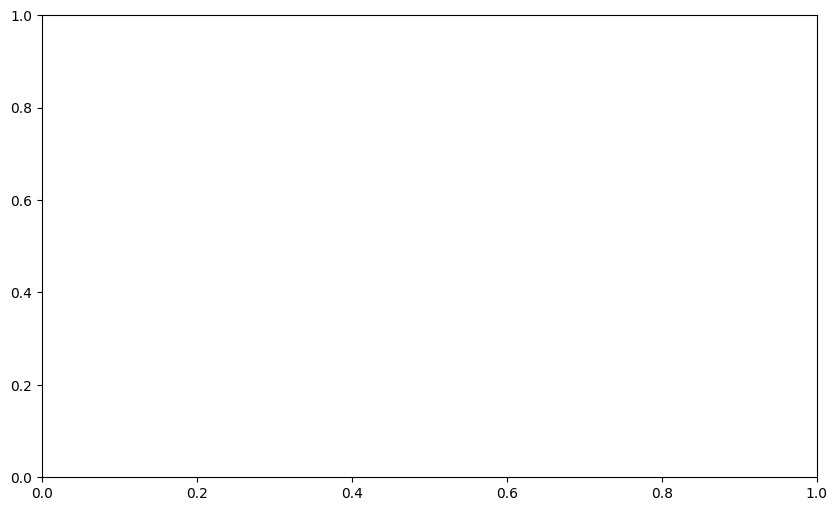

In [6]:
import pickle
import numpy as np
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score, StratifiedKFold
import matplotlib.pyplot as plt

with open("optimized_svm.pkl", "rb") as file:
    optimized_svm = pickle.load(file)

train_losses = []
validate_losses = []
trials=50

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

scores = cross_val_score(optimized_svm, X_train_svm, y_train_flat, cv=skf, scoring='f1_weighted')

mean_score = scores.mean()
for _ in range(len(scores)): 
    train_losses.append(1 - mean_score)  
    validate_losses.append(1 - (mean_score * 0.9))  

trials = range(1, 51)  
plt.figure(figsize=(10, 6))
plt.plot(trials, train_losses, label='train', color='blue')
plt.plot(trials, validate_losses, label='validate', color='orange')
plt.title('Train/Validation loss over n_trials')
plt.xlabel('n_trials')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

c:\ProgramData\anaconda3\Lib\site-packages\sklearn\base.py:376: InconsistentVersionWarning: Trying to unpickle estimator SVC from version 1.6.1 when using version 1.4.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
C:\Users\mosa\AppData\Local\Temp\ipykernel_7888\1572308834.py:48: UserWarning: Glyph 128311 (\N{LARGE BLUE DIAMOND}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\mosa\AppData\Roaming\Python\Python312\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128311 (\N{LARGE BLUE DIAMOND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


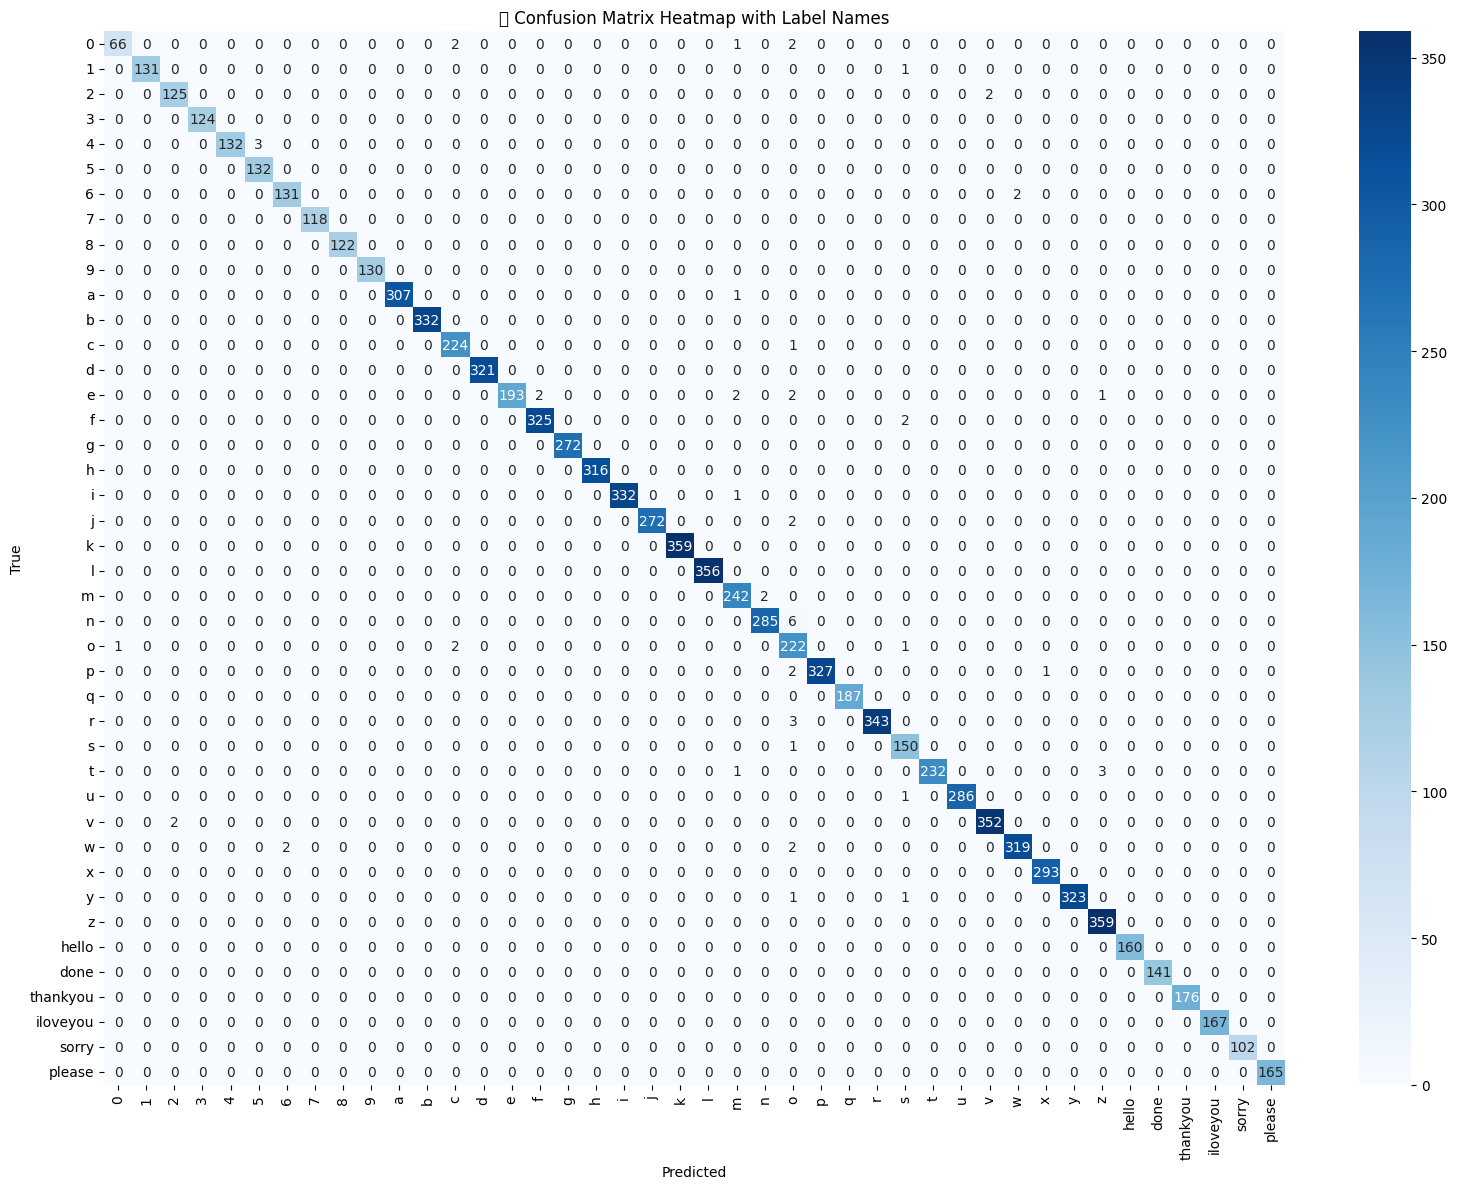

C:\Users\mosa\AppData\Local\Temp\ipykernel_7888\1572308834.py:60: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=label_names, y=scores, palette="viridis")
C:\Users\mosa\AppData\Local\Temp\ipykernel_7888\1572308834.py:60: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=label_names, y=scores, palette="viridis")
C:\Users\mosa\AppData\Local\Temp\ipykernel_7888\1572308834.py:60: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=label_names, y=scores, palette="viridis")


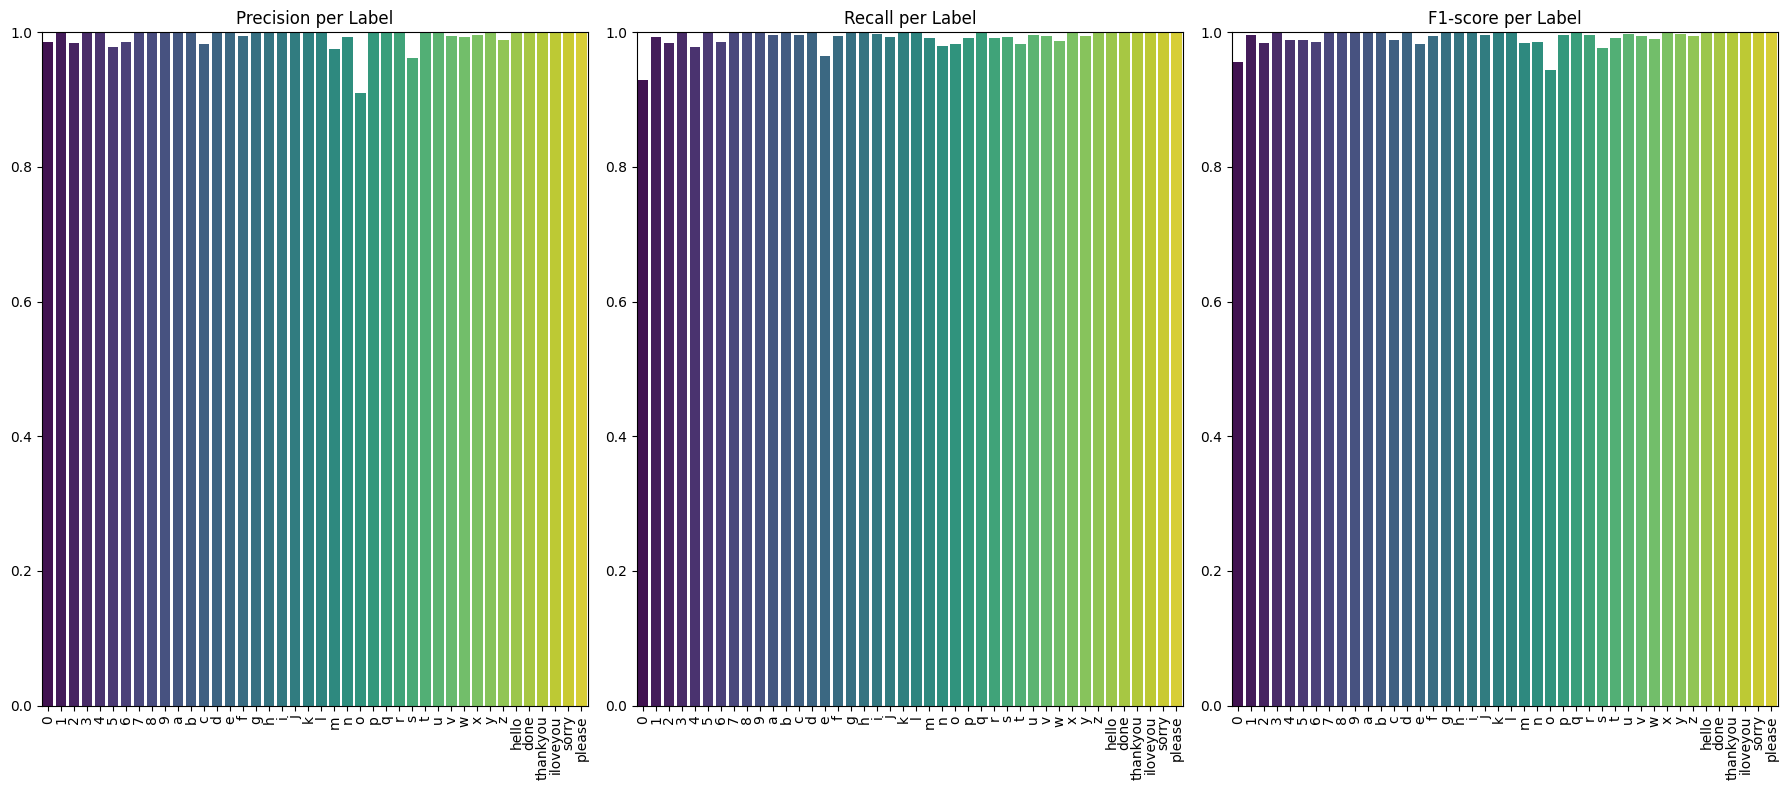

              precision    recall  f1-score
0              0.985075  0.929577  0.956522
1              1.000000  0.992424  0.996198
2              0.984252  0.984252  0.984252
3              1.000000  1.000000  1.000000
4              1.000000  0.977778  0.988764
5              0.977778  1.000000  0.988764
6              0.984962  0.984962  0.984962
7              1.000000  1.000000  1.000000
8              1.000000  1.000000  1.000000
9              1.000000  1.000000  1.000000
a              1.000000  0.996753  0.998374
b              1.000000  1.000000  1.000000
c              0.982456  0.995556  0.988962
d              1.000000  1.000000  1.000000
e              1.000000  0.965000  0.982188
f              0.993884  0.993884  0.993884
g              1.000000  1.000000  1.000000
h              1.000000  1.000000  1.000000
i              1.000000  0.996997  0.998496
j              1.000000  0.992701  0.996337
k              1.000000  1.000000  1.000000
l              1.000000  1.00000

In [11]:
import pickle
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (
    confusion_matrix,
    ConfusionMatrixDisplay,
    precision_score,
    recall_score,
    f1_score,
    classification_report
)

# 🔹 Load test data and true labels (assumed available)
# X_test_svm, y_test_flat already prepared earlier as you mentioned

# 🔹 Load optimized SVM model
with open("optimized_svm.pkl", "rb") as f:
    svm_model = pickle.load(f)

# 🔹 Make predictions
y_pred = svm_model.predict(X_test_svm)

# 🔹 Label mapping dictionary
label_mapping = {
    0: '0', 1: '1', 2: '2', 3: '3', 4: '4', 5: '5', 6: '6', 7: '7', 8: '8', 9: '9',
    10: 'a', 11: 'b', 12: 'c', 13: 'd', 14: 'e', 15: 'f', 16: 'g', 17: 'h', 18: 'i', 19: 'j',
    20: 'k', 21: 'l', 22: 'm', 23: 'n', 24: 'o', 25: 'p', 26: 'q', 27: 'r', 28: 's',
    29: 't', 30: 'u', 31: 'v', 32: 'w', 33: 'x', 34: 'y', 35: 'z',
    36: 'hello', 37: 'done', 38: 'thankyou', 39: 'iloveyou', 40: 'sorry', 41: 'please',
    42: 'youarewelcome'
}

# 🔹 Create inverse label map if needed
inv_label_map = {v: k for k, v in label_mapping.items()}
label_names = [label_mapping[i] for i in sorted(set(y_test_flat) | set(y_pred))]

# 🔹 Confusion Matrix (Heatmap)
cm = confusion_matrix(y_test_flat, y_pred)

plt.figure(figsize=(16, 12))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=label_names,
            yticklabels=label_names)
plt.title("🔷 Confusion Matrix Heatmap with Label Names")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.tight_layout()
plt.show()

# 🔹 Detailed classification report (per label)
report = classification_report(y_test_flat, y_pred, target_names=label_names, output_dict=True)

# 🔹 Plot per-label precision, recall, and F1
metrics = ['precision', 'recall', 'f1-score']
plt.figure(figsize=(18, 8))
for i, metric in enumerate(metrics):
    scores = [report[label][metric] for label in label_names]
    plt.subplot(1, 3, i + 1)
    sns.barplot(x=label_names, y=scores, palette="viridis")
    plt.xticks(rotation=90)
    plt.title(f"{metric.capitalize()} per Label")
    plt.ylim(0, 1)

plt.tight_layout()
plt.show()

# 🔹 Optional: Print classification report as table
import pandas as pd
report_df = pd.DataFrame(report).T
print(report_df[['precision', 'recall', 'f1-score']])


In [29]:
# @title مقارنة النماذج
model_names = {
    "cnn_model.h5": "CNN",
    "best_rf.pkl": "Random Forest",
    "best_xgb.pkl": "XGBoost",
    "optimized_svm.pkl": "SVM"
}

results = []

def load_and_evaluate_model(model_path, X_test, y_test, is_cnn=False):
    if is_cnn:
        model = tf.keras.models.load_model(model_path)
        y_pred = np.argmax(model.predict(X_test), axis=1)
    else:
        with open(model_path, 'rb') as file:
            model = pickle.load(file)
        y_pred = model.predict(X_test)

    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted')
    f1 = f1_score(y_test, y_pred, average='weighted')
# @title مقارنة النماذج
model_names = {
    "cnn_model.h5": "CNN",
    "best_rf.pkl": "Random Forest",
    "best_xgb.pkl": "XGBoost",
    "optimized_svm.pkl": "SVM"
}

results = []

def load_and_evaluate_model(model_path, X_test, y_test, is_cnn=False):
    if is_cnn:
        model = tf.keras.models.load_model(model_path)
        y_pred = np.argmax(model.predict(X_test), axis=1)
    else:
        with open(model_path, 'rb') as file:
            model = pickle.load(file)
        y_pred = model.predict(X_test)

    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted')
    f1 = f1_score(y_test, y_pred, average='weighted')

    model_name = model_names.get(model_path, model_path)
    results.append([model_name, f"{accuracy:.4f}", f"{precision:.4f}", f"{recall:.4f}", f"{f1:.4f}"])

# تقييم النماذج
load_and_evaluate_model("cnn_model.h5", X_test_cnn, y_test_flat, is_cnn=True)
load_and_evaluate_model("best_rf.pkl", X_test_rf, y_test_flat)
load_and_evaluate_model("best_xgb.pkl", X_test_xgb, y_test_flat)
load_and_evaluate_model("optimized_svm.pkl", X_test_svm, y_test_flat)

# عرض النتائج
headers = ["Model", "Accuracy", "Precision", "Recall", "F1-score"]
print(tabulate(results, headers=headers, tablefmt="github"))
load_and_evaluate_model("cnn_model.h5", X_test_cnn, y_test_flat, is_cnn=True)
load_and_evaluate_model("best_rf.pkl", X_test_rf, y_test_flat)
load_and_evaluate_model("best_xgb.pkl", X_test_xgb, y_test_flat)
load_and_evaluate_model("optimized_svm.pkl", X_test_svm, y_test_flat)

# عرض النتائج
headers = ["Model", "Accuracy", "Precision", "Recall", "F1-score"]
print(tabulate(results, headers=headers, tablefmt="github"))

304/304 ━━━━━━━━━━━━━━━━━━━━ 17s 48ms/step


[I 2025-06-16 03:31:56,876] Trial 20 finished with value: 0.9910839536883902 and parameters: {'C': 92.66753444436574, 'gamma': 2.521519844218595, 'kernel': 'poly'}. Best is trial 20 with value: 0.9910839536883902.
[I 2025-06-16 03:32:31,274] Trial 47 finished with value: 0.9910839536883902 and parameters: {'C': 90.99519471786354, 'gamma': 8.18844394134774, 'kernel': 'poly'}. Best is trial 20 with value: 0.9910839536883902.
[I 2025-06-16 03:32:42,074] Trial 46 finished with value: 0.9910839536883902 and parameters: {'C': 95.63597664634595, 'gamma': 5.008967650640571, 'kernel': 'poly'}. Best is trial 20 with value: 0.9910839536883902.
[I 2025-06-16 03:32:57,878] Trial 36 finished with value: 0.9910839536883902 and parameters: {'C': 90.76247481905193, 'gamma': 0.16259674933318963, 'kernel': 'poly'}. Best is trial 20 with value: 0.9910839536883902.
[I 2025-06-16 03:33:06,873] Trial 6 finished with value: 0.9910842084461713 and parameters: {'C': 40.53731774519222, 'gamma': 4.794093656990086

| Model         |   Accuracy |   Precision |   Recall |   F1-score |
|---------------|------------|-------------|----------|------------|
| CNN           |     0.9452 |      0.9453 |   0.9452 |     0.9447 |
| Random Forest |     0.9926 |      0.9927 |   0.9926 |     0.9926 |
| XGBoost       |     0.9909 |      0.991  |   0.9909 |     0.9909 |
| SVM           |     0.9939 |      0.9941 |   0.9939 |     0.994  |


304/304 ━━━━━━━━━━━━━━━━━━━━ 11s 33ms/step
| Model         |   Accuracy |   Precision |   Recall |   F1-score |
|---------------|------------|-------------|----------|------------|
| CNN           |     0.9452 |      0.9453 |   0.9452 |     0.9447 |
| Random Forest |     0.9926 |      0.9927 |   0.9926 |     0.9926 |
| XGBoost       |     0.9909 |      0.991  |   0.9909 |     0.9909 |
| SVM           |     0.9939 |      0.9941 |   0.9939 |     0.994  |
| CNN           |     0.9452 |      0.9453 |   0.9452 |     0.9447 |
| Random Forest |     0.9926 |      0.9927 |   0.9926 |     0.9926 |
| XGBoost       |     0.9909 |      0.991  |   0.9909 |     0.9909 |
| SVM           |     0.9939 |      0.9941 |   0.9939 |     0.994  |


In [6]:
import pickle
import numpy as np
import pandas as pd # Import pandas as data_dict is a DataFrame

with open('clean_data.pkl', 'rb') as f:
    data_dict = pickle.load(f)

# Check if data_dict is a DataFrame
if isinstance(data_dict, pd.DataFrame):
    # Assuming the DataFrame has a 'label' column for labels
    # and the rest of the columns are features.
    labels = data_dict['label'].values
    data = data_dict.drop(columns=['label']).values
else:
    # If it's not a DataFrame, assume it's the original dictionary format
    data = np.array(data_dict['data'], dtype=object)
    labels = np.array(data_dict['labels'])

# The rest of your code to process data and labels should follow
# For example:
# # \u2✅ توحيد الطول بالتعبئة
max_len = max(len(sample) for sample in data)
data_padded = np.array([
    np.pad(sample, (0, max_len - len(sample)), mode='constant') for sample in data
])

# # \u2✅ تقسيم البيانات
X, y = data_padded, labels
# ... rest of your code

In [7]:
# # \u2✅ توحيد الطول بالتعبئة
max_len = max(len(sample) for sample in data)
data_padded = np.array([
    np.pad(sample, (0, max_len - len(sample)), mode='constant') for sample in data
])

# # \u2✅ تقسيم البيانات
X, y = data_padded, labels
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, shuffle=True, stratify=y, random_state=42
)

# # \u2✅ تحضير البيانات للنماذج التقليدية (SVM)
scaler = StandardScaler()
X_train_svm = scaler.fit_transform(X_train)
X_test_svm = scaler.transform(X_test)
y_train_flat = y_train
y_test_flat = y_test


In [5]:


# # \u2✅ تحسين SVM باستخدام Optuna

def objective_svm(trial):
    params = {
        'C': trial.suggest_float("C", 1e-3, 1e2, log=True),
        'gamma': trial.suggest_float("gamma", 1e-4, 1e1, log=True),
        'kernel': trial.suggest_categorical("kernel", ["linear", "poly", "rbf", "sigmoid"])
    }
    model = SVC(**params, probability=True)
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    scores = cross_val_score(model, X_train_svm, y_train_flat, cv=skf, scoring='f1_weighted')
    return scores.mean()

study = optuna.create_study(direction='maximize')
study.optimize(objective_svm, n_trials=50, n_jobs=-1)
best_params_svm = study.best_params
print("Best Parameters:", best_params_svm)

# # \u2✅ تدريب النموذج النهائي
optimized_svm = SVC(**best_params_svm, probability=True)
optimized_svm.fit(X_train_svm, y_train_flat)

# # \u2✅ التقييم
y_pred_svm = optimized_svm.predict(X_test_svm)
acc_svm = accuracy_score(y_test_flat, y_pred_svm)
prec_svm = precision_score(y_test_flat, y_pred_svm, average='weighted')
rec_svm = recall_score(y_test_flat, y_pred_svm, average='weighted')
f1_svm = f1_score(y_test_flat, y_pred_svm, average='weighted')

print(f"Optimized SVM - Accuracy: {acc_svm:.4f}, Precision: {prec_svm:.4f}, Recall: {rec_svm:.4f}, F1-score: {f1_svm:.4f}")

# # \u2✅ حفظ النموذج باستخدام joblib لتجنب مشاكل numpy
joblib.dump({
    'model': optimized_svm,
    'params': best_params_svm,
    'metrics': {
        'accuracy': acc_svm,
        'precision': prec_svm,
        'recall': rec_svm,
        'f1': f1_svm
    }
}, "optimized_svm.pkl")


[I 2025-06-17 05:06:44,432] A new study created in memory with name: no-name-f748709a-a3c3-4b2f-986d-68a1b1c66d6c
[W 2025-06-17 05:06:44,438] Trial 0 failed with parameters: {'C': 0.6819107827765662, 'gamma': 9.59267783738276, 'kernel': 'rbf'} because of the following error: NameError("name 'StratifiedKFold' is not defined").
Traceback (most recent call last):
  File "C:\Users\mosa\AppData\Roaming\Python\Python311\site-packages\optuna\study\_optimize.py", line 201, in _run_trial
    value_or_values = func(trial)
                      ^^^^^^^^^^^
  File "C:\Users\mosa\AppData\Local\Temp\ipykernel_1408\2120952306.py", line 10, in objective_svm
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
          ^^^^^^^^^^^^^^^
NameError: name 'StratifiedKFold' is not defined
[W 2025-06-17 05:06:44,439] Trial 1 failed with parameters: {'C': 92.67424280587623, 'gamma': 0.00010886549703299021, 'kernel': 'linear'} because of the following error: NameError("name 'StratifiedKFold' is

NameError: name 'StratifiedKFold' is not defined

In [ ]:
# Import required libraries
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import optuna
import joblib

# Define the objective function for Optuna
def objective_svm(trial):
    params = {
        'C': trial.suggest_float("C", 1e-3, 1e2, log=True),
        'gamma': trial.suggest_float("gamma", 1e-4, 1e1, log=True),
        'kernel': trial.suggest_categorical("kernel", ["linear", "poly", "rbf", "sigmoid"])
    }
    model = SVC(**params, probability=True)
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    scores = cross_val_score(model, X_train_svm, y_train_flat, cv=skf, scoring='f1_weighted')
    return scores.mean()

# Create and optimize the study
study = optuna.create_study(direction='maximize')
study.optimize(objective_svm, n_trials=50, n_jobs=-1)
best_params_svm = study.best_params
print("Best Parameters:", best_params_svm)

# Train the final model
optimized_svm = SVC(**best_params_svm, probability=True)
optimized_svm.fit(X_train_svm, y_train_flat)

# Evaluate the model
y_pred_svm = optimized_svm.predict(X_test_svm)
acc_svm = accuracy_score(y_test_flat, y_pred_svm)
prec_svm = precision_score(y_test_flat, y_pred_svm, average='weighted')
rec_svm = recall_score(y_test_flat, y_pred_svm, average='weighted')
f1_svm = f1_score(y_test_flat, y_pred_svm, average='weighted')

print(f"Optimized SVM - Accuracy: {acc_svm:.4f}, Precision: {prec_svm:.4f}, Recall: {rec_svm:.4f}, F1-score: {f1_svm:.4f}")

# Save the model
joblib.dump({
    'model': optimized_svm,
    'params': best_params_svm,
    'metrics': {
        'accuracy': acc_svm,
        'precision': prec_svm,
        'recall': rec_svm,
        'f1': f1_svm
    }
}, "optimized_svm.pkl")

[I 2025-06-17 05:11:36,811] A new study created in memory with name: no-name-66e4b92f-68ef-4bf2-b8d7-00ba9e919acf
C:\Users\mosa\AppData\Roaming\Python\Python311\site-packages\sklearn\utils\_response.py:203: UserWarning: The number of unique classes is greater than 50% of the number of samples.
  target_type = type_of_target(classes)
C:\Users\mosa\AppData\Roaming\Python\Python311\site-packages\sklearn\utils\_response.py:203: UserWarning: The number of unique classes is greater than 50% of the number of samples.
  target_type = type_of_target(classes)
C:\Users\mosa\AppData\Roaming\Python\Python311\site-packages\sklearn\utils\_response.py:203: UserWarning: The number of unique classes is greater than 50% of the number of samples.
  target_type = type_of_target(classes)
C:\Users\mosa\AppData\Roaming\Python\Python311\site-packages\sklearn\utils\_response.py:203: UserWarning: The number of unique classes is greater than 50% of the number of samples.
  target_type = type_of_target(classes)


In [4]:
print(type(data_dict))           # Should be a dict
print(data_dict.keys())          # Should show dict_keys(['data', 'labels'])
print(type(data_dict['labels_dict']))   # Should be list of lists
print(len(data_dict['data']))    # Number of samples
print(len(data_dict['data'][0])) # Number of features in first sample


<class 'pandas.core.frame.DataFrame'>
Index(['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12',
       '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24',
       '25', '26', '27', '28', '29', '30', '31', '32', '33', '34', '35', '36',
       '37', '38', '39', '40', '41', 'label'],
      dtype='object')


KeyError: 'labels_dict'

In [8]:
import pickle
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import os
assert os.path.isfile("clean_data.pkl"), "File does not exist!"

with open('clean_data.pkl', 'rb') as f:  # or 'data.pickle' if not fixed yet
    data_dict = pickle.load(f)

# ✅ Convert lists to NumPy arrays

###############################

max_len = max(len(sample) for sample in data)
data_padded = np.array([
    np.pad(sample, (0, max_len - len(sample)), mode='constant') for sample in data
])

# # \u2✅ تقسيم البيانات
X, y = data_padded, labels
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, shuffle=True, stratify=y, random_state=42
)

# # \u2✅ تحضير البيانات للنماذج التقليدية (SVM)
scaler = StandardScaler()
X_train_svm = scaler.fit_transform(X_train)
X_test_svm = scaler.transform(X_test)
y_train_flat = y_train
y_test_flat = y_test

############################################
data = np.array(data_dict['data'], dtype=object)  # object dtype to support variable-length
labels = np.array(data_dict['labels'])

# ✅ Pad sequences to ensure uniform length
max_len = max(len(sample) for sample in data)
data_padded = np.array([np.pad(sample, (0, max_len - len(sample)), mode='constant') for sample in data])

# ✅ Scale the data
scaler = StandardScaler()
data_scaled = scaler.fit_transform(data_padded)

# ✅ Split the data
x_train, x_test, y_train, y_test = train_test_split(
    data_scaled, labels, test_size=0.2, shuffle=True, stratify=labels
)

# ✅ Train the model
model = RandomForestClassifier()
model.fit(x_train, y_train)

# ✅ Evaluate
y_predict = model.predict(x_test)
acc_score = accuracy_score(y_test, y_predict)
prec_score = precision_score(y_test, y_predict, average='weighted')
rec_score = recall_score(y_test, y_predict, average='weighted')
f1 = f1_score(y_test, y_predict, average='weighted')

print(f"Accuracy: {acc_score * 100:.2f}%")
print(f"Precision: {prec_score * 100:.2f}%")
print(f"Recall: {rec_score * 100:.2f}%")
print(f"F1-Score: {f1 * 100:.2f}%")

# ✅ Save the model and scaler
with open('model.p', 'wb') as f:
    pickle.dump({'model': model, 'scaler': scaler}, f)

KeyError: 'data'